In [1]:
%%capture
!pip install --upgrade wandb
!wandb login 3da7a23df9fd940d985adf808de2b09ceb85f15b

import wandb
wandb.init(project="global-wheat-detection", name='FasterRCNN with ResNet101 backbone: fold3')

In [2]:
%%capture
!pip install cython
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!cp /kaggle/input/rcnnutilswithwandb/engine.py .
!cp /kaggle/input/rcnnutilswithwandb/utils.py .
!cp /kaggle/input/rcnnutilswithwandb/coco_eval.py .
!cp /kaggle/input/rcnnutilswithwandb/coco_utils.py .
!cp /kaggle/input/rcnnutilswithwandb/transforms.py .

In [3]:
import os
import ast
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2

import torch
from PIL import Image
from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import StratifiedKFold

from torch import nn
import torchvision
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from matplotlib import pyplot as plt
import matplotlib.patches as patches

import utils
from engine import train_one_epoch, evaluate

In [4]:
# Constants
TEST_DIR = '/kaggle/input/global-wheat-detection/test'
BASE_DIR = '/kaggle/input/global-wheat-detection'
BATCH_SIZE = 2
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - background and wheat heads
N_CLASSES = 2
N_EPOCHS = 20

In [5]:
train_df = pd.read_csv(os.path.join('/kaggle/input/gwd5foldcsv/', 'train.csv'))
train_df.head()

image_id  x_min  y_min  x_max  y_max  width  height   area   source  kfold
0  b6ab77fd7    834    222    890    258     56      36   2016  usask_1      2
1  b6ab77fd7    226    548    356    606    130      58   7540  usask_1      2
2  b6ab77fd7    377    504    451    664     74     160  11840  usask_1      2
3  b6ab77fd7    834     95    943    202    109     107  11663  usask_1      2
4  b6ab77fd7     26    144    150    261    124     117  14508  usask_1      2

In [6]:
def get_train_augs():
    return A.Compose(
        [
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_augs():
    return A.Compose(
        [
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [7]:
class WheatDataset(Dataset):
    
    def __init__(self, df, folds, transforms=None):
        self.df = df[df.kfold.isin(folds)].reset_index(drop=True)
        self.image_ids = self.df['image_id'].unique()
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(os.path.join(BASE_DIR, 'train', f'{image_id}.jpg'), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # Get bbox coordinates for each wheat head(s)
        bboxes_df = self.df[self.df['image_id'] == image_id]
        boxes, areas = [], []
        n_objects = len(bboxes_df)  # Number of wheat heads in the given image

        for i in range(n_objects):
            x_min = bboxes_df.iloc[i]['x_min']
            x_max = bboxes_df.iloc[i]['x_max']
            y_min = bboxes_df.iloc[i]['y_min']
            y_max = bboxes_df.iloc[i]['y_max']

            boxes.append([x_min, y_min, x_max, y_max])
            areas.append(bboxes_df.iloc[i]['area'])
        
        # Get the labels. We have only one class (wheat head)
        labels = torch.ones((n_objects, ), dtype=torch.int64)
        
        areas = torch.as_tensor(areas)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((n_objects, ), dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([index]),
            'area': areas,
            'iscrowd': iscrowd
        }
        
        if self.transforms:
            result_aug = self.transforms(image=image, bboxes=np.array(boxes), labels=labels)
            image = result_aug['image'].float()

            if len(result_aug['bboxes']) != 0 :
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*result_aug['bboxes'])))).permute(1, 0)
            target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.int64)

        return image, target

In [8]:
def get_model(pre_trained=True):
    
    # Reference: https://stackoverflow.com/questions/58362892/resnet-18-as-backbone-in-faster-r-cnn
    resnet_net = torchvision.models.resnet101(pretrained=True) 
    modules = list(resnet_net.children())[:-2]

    backbone = nn.Sequential(*modules)
    backbone.out_channels = 2048

    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))

    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                       num_classes=N_CLASSES,
                       rpn_anchor_generator=anchor_generator)
    return model

In [9]:
%%capture
# get the model using our helper function
model = get_model()

In [10]:
num_classes = 2
train_dataset = WheatDataset(train_df, folds=[1, 2, 3, 4], transforms=get_train_augs())
train_loader = data_utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
0
val_dataset = WheatDataset(train_df, folds=[0], transforms=get_valid_augs())
val_loader = data_utils.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)


# move model to the right device
model.to(DEVICE)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

for epoch in range(N_EPOCHS):
    # train for one epoch, printing every 100 iterations
    train_one_epoch(model, optimizer, train_loader, DEVICE, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset
    evaluate(model, val_loader, device=DEVICE)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Epoch: [0]  [   0/1349]  eta: 2:11:33  lr: 0.000010  loss: 1.6256 (1.6256)  loss_classifier: 0.6656 (0.6656)  loss_box_reg: 0.0651 (0.0651)  loss_objectness: 0.6472 (0.6472)  loss_rpn_box_reg: 0.2478 (0.2478)  time: 5.8514  data: 3.3126  max mem: 5070


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Epoch: [0]  [ 100/1349]  eta: 0:13:19  lr: 0.000509  loss: 1.1675 (1.3151)  loss_classifier: 0.4205 (0.4603)  loss_box_reg: 0.2363 (0.1844)  loss_objectness: 0.3320 (0.4691)  loss_rpn_box_reg: 0.1732 (0.2013)  time: 0.8589  data: 0.3288  max mem: 6482
Epoch: [0]  [ 200/1349]  eta: 0:11:05  lr: 0.001009  loss: 1.1715 (1.2539)  loss_classifier: 0.4085 (0.4322)  loss_box_reg: 0.3127 (0.2390)  loss_objectness: 0.2592 (0.3887)  loss_rpn_box_reg: 0.1345 (0.1941)  time: 0.5151  data: 0.0111  max mem: 6482
Epoch: [0]  [ 300/1349]  eta: 0:09:47  lr: 0.001508  loss: 1.2147 (1.2205)  loss_classifier: 0.3930 (0.4144)  loss_box_reg: 0.4093 (0.2803)  loss_objectness: 0.2129 (0.3420)  loss_rpn_box_reg: 0.1559 (0.1838)  time: 0.5452  data: 0.0204  max mem: 6482
Epoch: [0]  [ 400/1349]  eta: 0:08:40  lr: 0.002008  loss: 1.0714 (1.1904)  loss_classifier: 0.3746 (0.4036)  loss_box_reg: 0.3960 (0.3078)  loss_objectness: 0.1586 (0.3044)  loss_rpn_box_reg: 0.1359 (0.1745)  time: 0.5131  data: 0.0103  max me

In [11]:
!rm -rf *

In [12]:
torch.save(model.state_dict(), 'fasterrcnn_augs_fold3.pth')

In [13]:
def get_bbox(bboxes, col, color='white'):
    
    for i in range(len(bboxes)):
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (bboxes[i][0], bboxes[i][1]),
            bboxes[i][2] - bboxes[i][0], 
            bboxes[i][3] - bboxes[i][1], 
            linewidth=2, 
            edgecolor=color, 
            facecolor='none')

        # Add the patch to the Axes
        col.add_patch(rect)

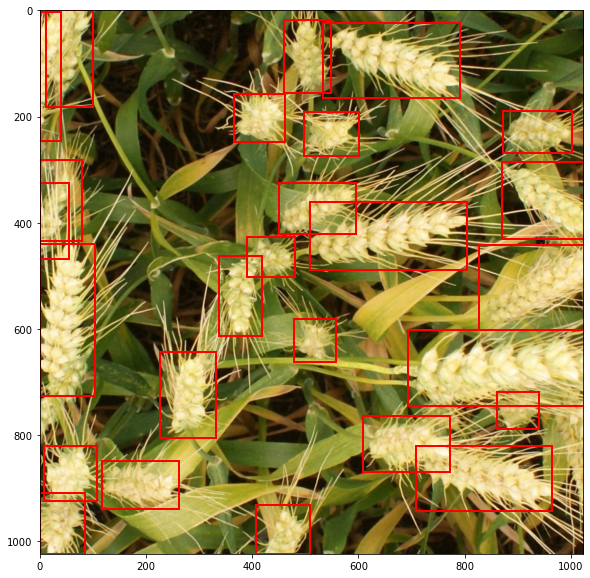

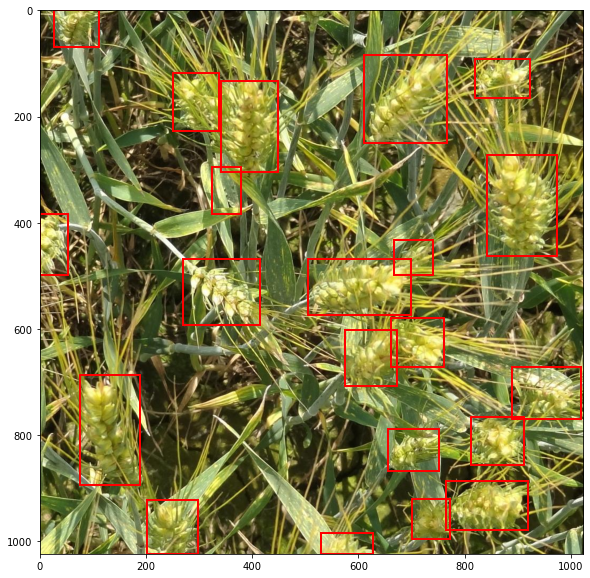

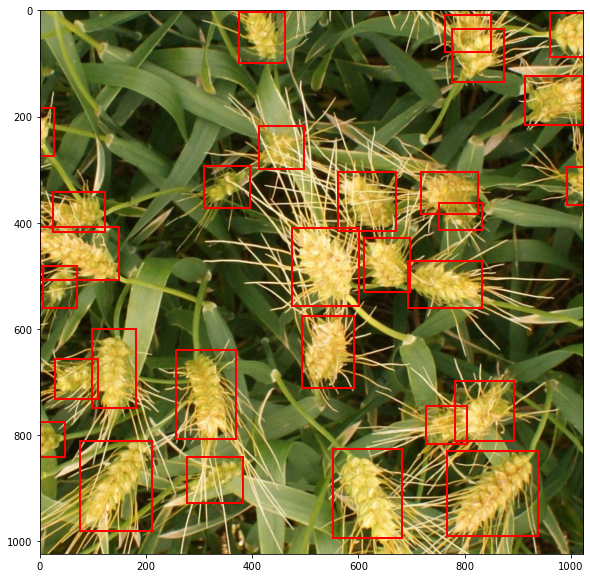

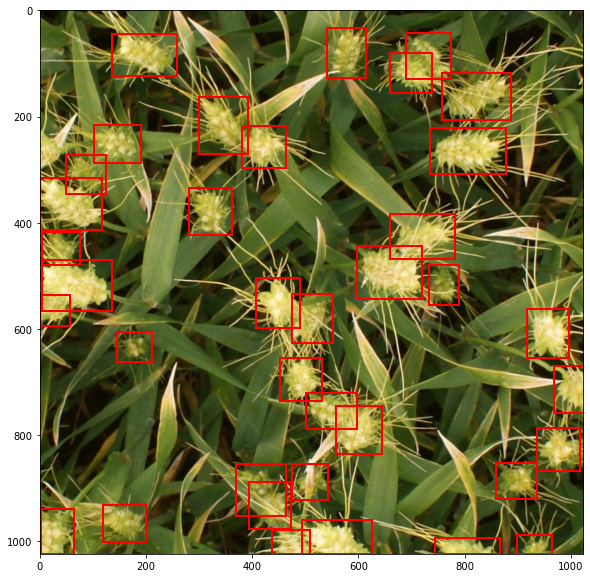

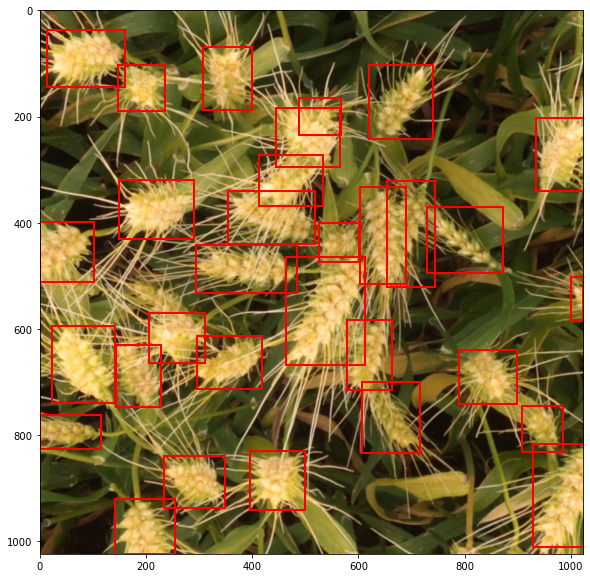

In [14]:
for img in os.listdir(TEST_DIR)[:5]:
    image = cv2.imread(os.path.join(TEST_DIR, img), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    preds = model([torch.from_numpy(np.transpose(image, (2, 0, 1))).to(DEVICE)])[0]
    
    pred_bboxes = preds['boxes'].cpu().detach().numpy()
    pred_scores = preds['scores'].cpu().detach().numpy()
    
    mask = pred_scores >= 0.4
    pred_scores = pred_scores[mask]
    pred_bboxes = pred_bboxes[mask]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    get_bbox(pred_bboxes, ax, color='red')
    ax.imshow(image)